<a href="https://colab.research.google.com/github/hyunjaec/MScA_Deep_Learning_Project/blob/main/zoning_satellite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
from scipy import ndimage, signal as sg
from skimage import data, filters, io, color
from sklearn.model_selection import train_test_split
from PIL import Image
import glob
import cv2
from google.colab.patches import cv2_imshow
import keras
from keras.datasets import mnist
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten,BatchNormalization, Input, ZeroPadding2D
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import applications
from skimage.filters.rank import median, mean

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [2]:
!pwd

/content


In [3]:
#connect colab with google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
#label csv
austin_df = pd.read_csv("/content/drive/My Drive/Data/data/austin.csv")
austin_df = austin_df.drop('Unnamed: 0', axis = 1)
austin_df.head()

,image_name,zoning_id,zoning_zty
0,data/austin_0.jpg,229791,PUD
1,data/austin_1.jpg,229791,PUD
2,data/austin_2.jpg,400523442,I-RR
3,data/austin_3.jpg,229791,PUD
4,data/austin_4.jpg,229791,PUD


In [5]:
residential = ['LA',
            'RR',
            'SF-1',
            'SF-2',
            'SF-3',
            'SF-4A',
            'SF-4-A,'
            'SF-4B',
            'SF-5',
            'SF-6',
            'MF-1',
            'MF-2',
            'MF-3',
            'MF-4',
            'MF-5',
            'MF-6',
            'MF-CO',
            'MH']

commercial = ['NO',
            'LO',
            'GO',
            'CR',
            'LR',
            'GR',
            'L',
            'CBD',
            'DMU',
            'W/LO',
            'CS',
            'CS-1',
            'CH']

industrial_special = ['DR', 'AV', 'AG', 'P', 'PUD', 'TN', 'ERC', 'UNZ','IP', 'LI', 'MI', 'R&D']

In [6]:
#loop through list of zone codes, map specific zone codes to R, C, I, or S
austin_df.loc[:, 'zone'] = np.nan

for i in residential:
    austin_df.loc[:, 'zone'] = np.where(austin_df.loc[:, 'zoning_zty'].str.contains(i) == True, 
                                     'R', austin_df.loc[:,'zone'])
for i in commercial:
    austin_df.loc[:, 'zone'] = np.where((austin_df.loc[:, 'zoning_zty'].str.contains(i) == True) & \
                                     (austin_df.loc[:, 'zone'] != 'R'), 
                                     'C', austin_df.loc[:,'zone'])
for i in industrial_special:
    austin_df.loc[:, 'zone'] = np.where((austin_df.loc[:, 'zoning_zty'].str.contains(i) == True) & \
                                     (austin_df.loc[:, 'zone'] != 'R') &\
                                     (austin_df.loc[:, 'zone'] != 'C'), 
                                     'IS', austin_df.loc[:,'zone'])

In [7]:
#manually set this one
austin_df.loc[303, 'zone'] = 'R'

In [8]:
austin_df.head()

,image_name,zoning_id,zoning_zty,zone
0,data/austin_0.jpg,229791,PUD,IS
1,data/austin_1.jpg,229791,PUD,IS
2,data/austin_2.jpg,400523442,I-RR,R
3,data/austin_3.jpg,229791,PUD,IS
4,data/austin_4.jpg,229791,PUD,IS


(array([1278.,    0.,    0.,    0.,    0., 1747.,    0.,    0.,    0.,
         642.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

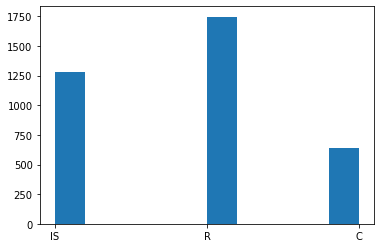

In [9]:
plt.hist(austin_df['zone'])

In [10]:
img_names = austin_df['image_name']

In [11]:
dim = (200, 200)

In [12]:
# img_df = []
# # for i in img_names:
# #     img_df.append(cv2.imread(('../'+ str(i))))
# for i, img in enumerate(img_names):
#     visual_img = image.load_img(('/content/drive/My Drive/Data/'+img), target_size=dim)  
#     img_array = image.img_to_array(visual_img)
#     img_array = median(img_array, 1.0/9.0 * np.ones((3, 3)))
#     img_df.append(img_array)

In [13]:
dim = (200, 200)
img_df = []
for i in img_names:
  visual_img = cv2.imread("/content/drive/My Drive/Data/" + str(i[:-4])+".jpg")
  visual_img = cv2.resize(visual_img, dim, interpolation = cv2.INTER_AREA)
  visual_img = cv2.fastNlMeansDenoisingColored(visual_img,None,10,10,7,15)
  img_df.append(visual_img)

In [14]:
img_array = np.array(img_df) 
img_array.shape

(3667, 200, 200, 3)

In [15]:
#make images equal pixel by 500, 500 
# for i, img in enumerate(img_df):
#   img_df[i] = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

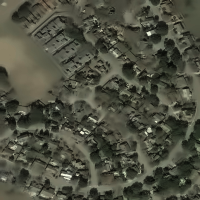

In [16]:
cv2_imshow(img_array[53])

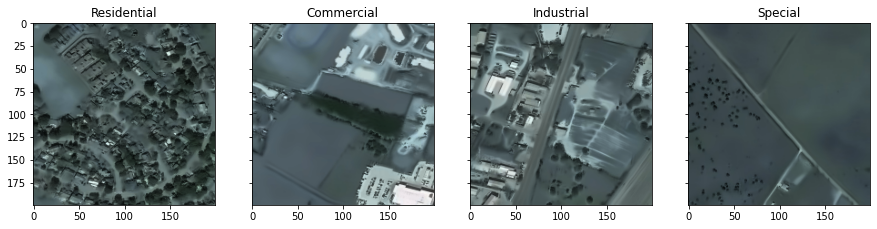

In [17]:
fig, ax = plt.subplots(1, 4, figsize=(15, 15), sharex=True, sharey=True)
ax1, ax2, ax3, ax4 = ax.ravel()

ax1.imshow(np.array(img_array[53],np.int32))
ax1.set_title('Residential')

ax2.imshow(np.array(img_array[138],np.int32))
ax2.set_title('Commercial')

ax3.imshow(np.array(img_array[397],np.int32))
ax3.set_title('Industrial')

ax4.imshow(np.array(img_array[72],np.int32))
ax4.set_title('Special')


plt.show()

In [59]:
img_df2 = np.array(img_df) 
zone_class = np.array(austin_df['zone']) 
zone_class = pd.get_dummies(zone_class)
#split labels and images for train&test
X_train, X_test, y_train, y_test = train_test_split(img_df2, zone_class, test_size=.15)
input_shape = (200, 200, 3)

In [60]:
datagen = ImageDataGenerator(
#     rotation_range=30,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     horizontal_flip=True,
#     validation_split=0.2
    rescale=1.0/255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
    )

datagen.fit(X_train)

In [61]:
model = Sequential()
model.add(Conv2D(128, kernel_size=(3, 3),
                 activation='relu', 
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(200, activation='relu'))
model.add(Dense(3, activation='softmax'))

In [62]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 198, 198, 128)     3584      
                                                                 
 conv2d_4 (Conv2D)           (None, 196, 196, 64)      73792     
                                                                 
 batch_normalization_2 (Batc  (None, 196, 196, 64)     256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 98, 98, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 96, 96, 64)        36928     
                                                                 
 batch_normalization_3 (Batc  (None, 96, 96, 64)      

In [63]:
# model = applications.efficientnet_v2.EfficientNetV2L(weights = "imagenet", include_top=False, input_shape = (200, 200, 3))

In [64]:
#model.summary()

In [65]:
# x = model.output
# x = Flatten()(x)
# x = Dense(1024, activation="relu")(x)
# x = Dropout(0.5)(x)
# x = Dense(1024, activation="relu")(x)
# predictions = Dense(4, activation="softmax")(x)

# # creating the final model 
# model_final = Model(model.input, predictions)

In [66]:
#model_final.summary()

In [67]:
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.0001), loss=keras.losses.categorical_crossentropy, metrics=["accuracy"])

In [68]:
batch_size = 64
epochs = 50

In [69]:
X_test.shape

(551, 200, 200, 3)

In [70]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size, subset='training'), 
                    validation_data=datagen.flow(X_train, y_train, subset='validation'),
                    epochs=epochs)

Epoch 1/50
39/39 [==============================] - 29s 737ms/step - loss: 2.1163 - accuracy: 0.5315 - val_loss: 2.0052 - val_accuracy: 0.1589
Epoch 2/50
39/39 [==============================] - 28s 706ms/step - loss: 0.9403 - accuracy: 0.5844 - val_loss: 1.7281 - val_accuracy: 0.4013
Epoch 3/50
39/39 [==============================] - 28s 707ms/step - loss: 0.8939 - accuracy: 0.6021 - val_loss: 2.6466 - val_accuracy: 0.3884
Epoch 4/50
39/39 [==============================] - 28s 706ms/step - loss: 0.8635 - accuracy: 0.6169 - val_loss: 2.9380 - val_accuracy: 0.3965
Epoch 5/50
39/39 [==============================] - 27s 704ms/step - loss: 0.8646 - accuracy: 0.6153 - val_loss: 3.0555 - val_accuracy: 0.4205
Epoch 6/50
39/39 [==============================] - 27s 702ms/step - loss: 0.8642 - accuracy: 0.6073 - val_loss: 2.8159 - val_accuracy: 0.4687
Epoch 7/50
39/39 [==============================] - 28s 705ms/step - loss: 0.8616 - accuracy: 0.6149 - val_loss: 2.6623 - val_accuracy: 0.4607

In [71]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score)

Test loss: [22.78292465209961, 0.5589836835861206]


Text(0.5, 1.0, 'Loss Curves')

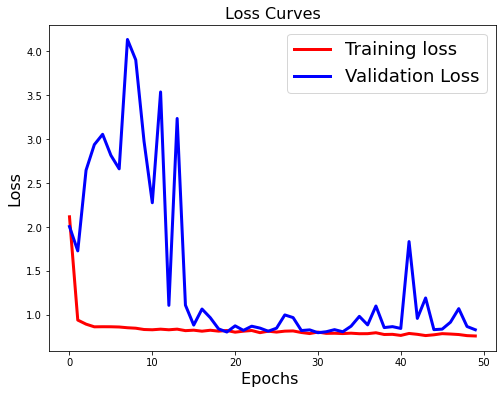

In [72]:
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

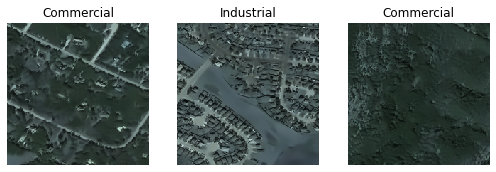

In [74]:
class_names = ['Residnetial', 'Commercial', 'Industrial','Speical']
images_and_labels = list(zip(X_test, y_test))
plt.figure(figsize=(30,30))
for index, (image, label) in enumerate(images_and_labels):
    plt.subplot(4, 10, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    index = np.where(label == 1)
    imagedata = image[np.newaxis, :, :]
    pred = model.predict(imagedata)
    pred= pred[0].argmax(axis=0)
    plt.title(class_names[pred])
plt.show()